In [1]:
import pandas as pd
import numpy as np
import sys

sys.path.append("../")

from src import util
from src.transformation import transform
from src import config
from src import subject_manipulation
from typing import Tuple, List
from src.config import SUBJECT_DF_PATH, BLANK_ANSWER_LABEL, DELETION_ANSWER_LABEL, CANCELLED_LABEL, DIFFICULTIES, \
    MATH_SUBJECTS, COMPUTING_SUBJECTS, HUMAN_SUBJECTS, TECHNOLOGY_SUBJECTS
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.patches as mpatches
import os

In [2]:
def read_csv_course(year, filter_by_course):
    df = transform.read_csv(year)
    if filter_by_course:
        df = df.loc[df["CO_CURSO"] == config.CODE_COURSE]
    return df

In [3]:
years = [2017, 2014, 2011, 2008, 2005]

In [4]:
def get_dict_all_years(filter_by_course: bool) -> dict:
        
    result = {}
    for year in years:
        result[year] = read_csv_course(year, filter_by_course=filter_by_course)
        
    return result

In [5]:
def display_all_years_nota(all_dfs: dict) -> pd.DataFrame:
    data = {"2005": all_dfs[2005]["Nota %"].copy(),
            "2008": all_dfs[2008]["Nota %"].copy(),
            "2011": all_dfs[2011]["Nota %"].copy(),
            "2014": all_dfs[2014]["Nota %"].copy(),
            "2017": all_dfs[2017]["Nota %"].copy()}
    return pd.DataFrame(data)

In [6]:
"""Numero de questões respondidas por categoria considerando todos os anos
    
    contador para cada categoria iniciado em 0
    para cada prova
        para cada categoria
            multiplicar numero de presentes pelo numero de questões da categoria
            incrementar o contador da categoria
     """

def return_num_answered(display_dfs, original_dfs, multiply_by_students=True):
    num_questions_answered_dfs = []
    for year in display_dfs.keys():
        df = display_dfs[year]
        num_questions = df["Nº Questões"].astype(int).copy()
        if multiply_by_students:
            num_questions *= original_dfs[year].shape[0]
        num_questions_answered_dfs.append(num_questions)
    num_questions_answered_df = pd.concat(num_questions_answered_dfs, axis=1)
    num_answered_by_category = num_questions_answered_df.fillna(0).sum(axis=1).sort_index()
    return num_answered_by_category

"""Numero de questões respondidas corretamente por categoria considerando todos os anos
    
    contador para cada categoria iniciado em 0
    para cada prova
        para cada categoria
            multiplicar numero de presentes pelo numero de questões acertadas da categoria
            incrementar o contador da categoria
     """

def return_num_correct(dfs, categories):
    columns = [f"ACERTOS_OBJ_{x}" for x in categories]
    correct_by_category  = pd.concat(dfs.values(), ignore_index=True)
    correct_by_category = correct_by_category[columns].sum(0).sort_index()
    return correct_by_category
    

def get_all_years_combined_df(display_dfs, dfs, categories):
    num_answered = return_num_answered(display_dfs, dfs)
    num_correct = return_num_correct(dfs, categories)
    num_correct.index = num_answered.index
    data_df = {"Questões Respondidas no total (Questões x Alunos)": num_answered,
               "Acertos no Total (Acertos x Alunos)": num_correct}
    score_df_category = pd.DataFrame(data_df)
    score_df_category["Nota %"] = score_df_category.iloc[:, 1]*100/score_df_category.iloc[:, 0]
    score_df_category.iloc[:, 0] =  score_df_category.iloc[:, 0].astype(int)
    score_df_category.iloc[:, 1] =  score_df_category.iloc[:, 1].astype(int)

    score_df_category["Nota %"] = score_df_category["Nota %"].round(2)
    
    return score_df_category.sort_values(by=["Nota %"])

In [7]:
path = os.path.join("data", "raw_data", "dificuldade_questao.csv")
difficulty_df = pd.read_csv(path)

In [8]:
def get_display_df_difficulty(year: int, input_df: pd.DataFrame,
                              difficulty_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
   
    temp_difficulty_df = difficulty_df.loc[difficulty_df['ano'] == year].copy()
    
    util.map_presence(input_df)
    presence_df = input_df["TP_PRES"].value_counts()
    
    input_df = util.filter_present_students(input_df)
    
    input_df = util.add_all_score_categories(input_df, temp_difficulty_df, True,
                                             DIFFICULTIES, util.get_difficulty_valid_questions)
        
    categories = DIFFICULTIES
    
    num_questions = []
    mean_acertos = []
    std_acertos = []
    column_zero = []
    column_geq_one = []
    column_all = []
    num_alunos = input_df.shape[0]

    
    for category in categories:
        questions = util.get_difficulty_valid_questions(category, 
                                                             temp_difficulty_df,
                                                             input_df)
        num_obj_questions = len(questions)
    
        mean_acertos_category = input_df[f"ACERTOS_OBJ_{category}"].mean()
    
        std_acertos_category = input_df[f"ACERTOS_OBJ_{category}"].std()
        
        zero_category_percentage = list(input_df[f"ACERTOS_OBJ_{category}"]).count(0) * 100 / num_alunos
    
        geq_one_category_percentage = list(input_df[f"ACERTOS_OBJ_{category}"] >= 1).count(True) * 100 / num_alunos
        
        all_category_percentage = list(input_df[f"ACERTOS_OBJ_{category}"] == num_obj_questions).count(True) * 100 / num_alunos
        
        if num_obj_questions > 0:
            num_questions.append(num_obj_questions)
            mean_acertos.append(mean_acertos_category)
            std_acertos.append(std_acertos_category)
            column_zero.append(zero_category_percentage)
            column_geq_one.append(geq_one_category_percentage)
            column_all.append(all_category_percentage)
        else:
            num_questions.append(0)
            mean_acertos.append(None)
            std_acertos.append(None)
            column_zero.append(None)
            column_geq_one.append(None)
            column_all.append(None)

    category_labels = [f"SCORE_OBJ_{x}" for x in categories]

    mean_by_category = input_df[category_labels].mean().values

    data = np.array([mean_by_category, num_questions]).T

    display_df = pd.DataFrame(data=data, index=categories, 
                          columns=["Nota %", "Nº Questões"])
    display_df["Nº Questões"] = display_df["Nº Questões"].astype(int, errors="ignore")
    display_df["Média Acertos"] = mean_acertos
    display_df["Desvio Padrão Acertos"] = std_acertos
    display_df["% de Zeros"] = column_zero

    display_df["% de Alunos que acertaram pelo menos uma questão"] = column_geq_one
    display_df["% de Alunos que acertaram todas"] = column_all


    display_df = display_df.sort_values(by=["Nota %"]).round(2)

    
    return display_df, input_df


In [9]:
enade_all_years_course = get_dict_all_years(filter_by_course=True)
enade_all_years_br = get_dict_all_years(filter_by_course=False)

In [10]:
def get_display_dfs_difficulty(enade_all_years_dict: dict) -> dict:
    result = {}
    for year in enade_all_years_dict.keys():
        display_df, enade_all_years_dict[year] = get_display_df_difficulty(year,
                                                                           enade_all_years_dict[year],
                                                                           difficulty_df)
        result[year] = display_df
    return result

display_dfs_difficulty_course = get_display_dfs_difficulty(enade_all_years_course)
display_dfs_difficulty_br = get_display_dfs_difficulty(enade_all_years_br)

/home/renan/.local/share/virtualenvs/KDD-HigherEduBR-KpG9-Zor/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/renan/.local/share/virtualenvs/KDD-HigherEduBR-KpG9-Zor/lib/python3.6/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/home/renan/.local/share/virtualenvs/KDD-HigherEduBR-KpG9-Zor/lib/python3.6/site-packages/pandas/core/indexing.py:

/home/renan/.local/share/virtualenvs/KDD-HigherEduBR-KpG9-Zor/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/renan/.local/share/virtualenvs/KDD-HigherEduBR-KpG9-Zor/lib/python3.6/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/home/renan/.local/share/virtualenvs/KDD-HigherEduBR-KpG9-Zor/lib/python3.6/site-packages/pandas/core/indexing.py:

/home/renan/.local/share/virtualenvs/KDD-HigherEduBR-KpG9-Zor/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/renan/.local/share/virtualenvs/KDD-HigherEduBR-KpG9-Zor/lib/python3.6/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/home/renan/.local/share/virtualenvs/KDD-HigherEduBR-KpG9-Zor/lib/python3.6/site-packages/pandas/core/indexing.py:

/home/renan/.local/share/virtualenvs/KDD-HigherEduBR-KpG9-Zor/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/renan/.local/share/virtualenvs/KDD-HigherEduBR-KpG9-Zor/lib/python3.6/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


/home/renan/.local/share/virtualenvs/KDD-HigherEduBR-KpG9-Zor/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/renan/.local/share/virtualenvs/KDD-HigherEduBR-KpG9-Zor/lib/python3.6/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


/home/renan/.local/share/virtualenvs/KDD-HigherEduBR-KpG9-Zor/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/renan/.local/share/virtualenvs/KDD-HigherEduBR-KpG9-Zor/lib/python3.6/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


/home/renan/.local/share/virtualenvs/KDD-HigherEduBR-KpG9-Zor/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/renan/.local/share/virtualenvs/KDD-HigherEduBR-KpG9-Zor/lib/python3.6/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [11]:

print("Curso - 2017")
display_dfs_difficulty_course[2017]

Curso - 2017


,Nota %,Nº Questões,Média Acertos,Desvio Padrão Acertos,% de Zeros,% de Alunos que acertaram pelo menos uma questão,% de Alunos que acertaram todas
dificil,31.83,17,5.41,2.16,0.00,100.00,0.00
medio,54.41,8,4.35,1.63,0.00,100.00,0.00
facil,77.45,6,4.65,1.01,0.00,100.00,20.59
muito facil,97.06,1,0.97,0.17,2.94,97.06,97.06
muito dificil,NaN,0,NaN,NaN,NaN,NaN,NaN


In [12]:
print("Brasil - 2017")
display_dfs_difficulty_br[2017]


Brasil - 2017


,Nota %,Nº Questões,Média Acertos,Desvio Padrão Acertos,% de Zeros,% de Alunos que acertaram pelo menos uma questão,% de Alunos que acertaram todas
dificil,31.46,17,5.35,2.52,0.85,99.15,0.00
medio,51.28,8,4.10,1.70,1.35,98.65,1.48
facil,68.18,6,4.09,1.40,1.18,98.82,15.68
muito facil,87.56,1,0.88,0.33,12.44,87.56,87.56
muito dificil,NaN,0,NaN,NaN,NaN,NaN,NaN


In [13]:
print("Curso - 2014")
display_dfs_difficulty_course[2014]

Curso - 2014


,Nota %,Nº Questões,Média Acertos,Desvio Padrão Acertos,% de Zeros,% de Alunos que acertaram pelo menos uma questão,% de Alunos que acertaram todas
muito dificil,17.86,1,0.18,0.39,82.14,17.86,17.86
dificil,28.57,12,3.43,1.26,0.00,100.00,0.00
medio,46.43,6,2.79,1.20,3.57,96.43,0.00
facil,76.79,10,7.68,1.70,0.00,100.00,10.71
muito facil,NaN,0,NaN,NaN,NaN,NaN,NaN


In [14]:
print("Brasil - 2014")

display_dfs_difficulty_br[2014]

Brasil - 2014


,Nota %,Nº Questões,Média Acertos,Desvio Padrão Acertos,% de Zeros,% de Alunos que acertaram pelo menos uma questão,% de Alunos que acertaram todas
muito dificil,14.27,1,0.14,0.35,85.73,14.27,14.27
dificil,30.47,12,3.66,1.96,2.50,97.50,0.02
medio,52.39,6,3.14,1.42,2.68,97.32,4.76
facil,71.62,10,7.16,2.04,0.36,99.64,10.78
muito facil,NaN,0,NaN,NaN,NaN,NaN,NaN


In [15]:
print("Curso - 2011")
display_dfs_difficulty_course[2011]

Curso - 2011


,Nota %,Nº Questões,Média Acertos,Desvio Padrão Acertos,% de Zeros,% de Alunos que acertaram pelo menos uma questão,% de Alunos que acertaram todas
muito dificil,5.88,2,0.12,0.33,88.24,11.76,0.00
dificil,37.02,17,6.29,2.20,0.00,100.00,0.00
medio,68.63,6,4.12,1.17,0.00,100.00,11.76
facil,82.35,4,3.29,0.59,0.00,100.00,35.29
muito facil,NaN,0,NaN,NaN,NaN,NaN,NaN


In [16]:
print("Brasil - 2011")

display_dfs_difficulty_br[2011]

Brasil - 2011


,Nota %,Nº Questões,Média Acertos,Desvio Padrão Acertos,% de Zeros,% de Alunos que acertaram pelo menos uma questão,% de Alunos que acertaram todas
muito dificil,15.20,2,0.30,0.50,71.74,28.26,2.15
dificil,26.99,17,4.59,2.46,2.44,97.56,0.00
medio,47.27,6,2.84,1.44,5.52,94.48,2.24
facil,70.32,4,2.81,1.11,4.45,95.55,31.56
muito facil,NaN,0,NaN,NaN,NaN,NaN,NaN


In [17]:
print("Curso - 2008")
display_dfs_difficulty_course[2008]

Curso - 2008


,Nota %,Nº Questões,Média Acertos,Desvio Padrão Acertos,% de Zeros,% de Alunos que acertaram pelo menos uma questão,% de Alunos que acertaram todas
muito dificil,19.44,4,0.78,0.87,41.67,58.33,2.78
dificil,31.39,20,6.28,2.02,0.00,100.00,0.00
medio,56.94,8,4.56,1.18,0.00,100.00,0.00
facil,86.11,3,2.58,0.50,0.00,100.00,58.33
muito facil,NaN,0,NaN,NaN,NaN,NaN,NaN


In [18]:
print("Brasil - 2008")

display_dfs_difficulty_br[2008]

Brasil - 2008


,Nota %,Nº Questões,Média Acertos,Desvio Padrão Acertos,% de Zeros,% de Alunos que acertaram pelo menos uma questão,% de Alunos que acertaram todas
muito dificil,15.18,4,0.61,0.82,56.73,43.27,0.50
dificil,29.92,20,5.98,2.86,2.11,97.89,0.00
medio,55.58,8,4.45,1.70,1.90,98.10,2.22
facil,76.29,3,2.29,0.86,4.80,95.20,50.79
muito facil,NaN,0,NaN,NaN,NaN,NaN,NaN


In [19]:
print("Curso - 2005")
display_dfs_difficulty_course[2005]

Curso - 2005


,Nota %,Nº Questões,Média Acertos,Desvio Padrão Acertos,% de Zeros,% de Alunos que acertaram pelo menos uma questão,% de Alunos que acertaram todas
muito dificil,15.00,2,0.30,0.47,70.00,30.00,0.00
dificil,28.82,17,4.90,2.62,3.33,96.67,0.00
medio,62.67,5,3.13,1.07,0.00,100.00,10.00
facil,81.67,4,3.27,0.91,0.00,100.00,53.33
muito facil,93.33,1,0.93,0.25,6.67,93.33,93.33


In [20]:
print("Brasil - 2005")

display_dfs_difficulty_br[2005]

Brasil - 2005


,Nota %,Nº Questões,Média Acertos,Desvio Padrão Acertos,% de Zeros,% de Alunos que acertaram pelo menos uma questão,% de Alunos que acertaram todas
muito dificil,14.07,2,0.28,0.50,74.34,25.66,2.48
dificil,28.06,17,4.77,2.73,4.32,95.68,0.00
medio,55.40,5,2.77,1.33,5.69,94.31,9.46
facil,76.91,4,3.08,1.05,3.37,96.63,43.76
muito facil,90.53,1,0.91,0.29,9.47,90.53,90.53


In [21]:
print("Nota % por ano - Curso")
display_all_years_nota(display_dfs_difficulty_course)

Nota % por ano - Curso


,2005,2008,2011,2014,2017
dificil,28.82,31.39,37.02,28.57,31.83
facil,81.67,86.11,82.35,76.79,77.45
medio,62.67,56.94,68.63,46.43,54.41
muito dificil,15.00,19.44,5.88,17.86,NaN
muito facil,93.33,NaN,NaN,NaN,97.06


In [22]:
print("Nota % por ano - Brasil")
display_all_years_nota(display_dfs_difficulty_br)

Nota % por ano - Brasil


,2005,2008,2011,2014,2017
dificil,28.06,29.92,26.99,30.47,31.46
facil,76.91,76.29,70.32,71.62,68.18
medio,55.40,55.58,47.27,52.39,51.28
muito dificil,14.07,15.18,15.20,14.27,NaN
muito facil,90.53,NaN,NaN,NaN,87.56


In [23]:
print("Brasil")
difficulty_all_br_df = get_all_years_combined_df(display_dfs_difficulty_br, enade_all_years_br, DIFFICULTIES)
difficulty_all_br_df

Brasil


,Questões Respondidas no total (Questões x Alunos),Acertos no Total (Acertos x Alunos),Nota %
muito dificil,67136,9972,14.85
dificil,653901,191384,29.27
medio,261690,135981,51.96
facil,219259,157094,71.65
muito facil,15223,13529,88.87


In [24]:
print("Curso")
difficulty_all_course_df = get_all_years_combined_df(display_dfs_difficulty_course, enade_all_years_course, DIFFICULTIES)
difficulty_all_course_df

Curso


,Questões Respondidas no total (Questões x Alunos),Acertos no Total (Acertos x Alunos),Nota %
muito dificil,266,44,16.54
dificil,2433,760,31.24
medio,980,554,56.53
facil,780,620,79.49
muito facil,64,61,95.31


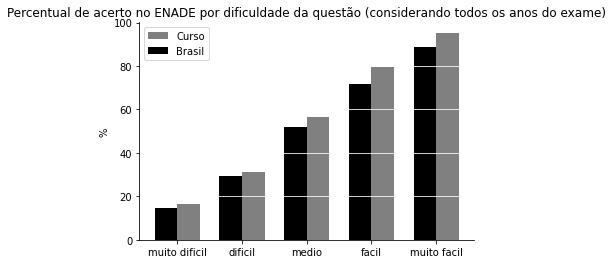

In [25]:
N = 5
br = difficulty_all_br_df["Nota %"]
course = difficulty_all_course_df["Nota %"]
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

ax = plt.subplot(111)
p2 = ax.bar(ind - width/2, br, width, color="black")
p1 = ax.bar(ind + width/2, course, width, color="gray")


plt.ylabel('%')
plt.title('Percentual de acerto no ENADE por dificuldade da questão (considerando todos os anos do exame)')
plt.xticks(ind, difficulty_all_br_df.index)
#plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Curso', 'Brasil'))
ax.grid(axis = 'y', color ='white', linestyle='-')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()